In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
palette = 'colorblind'
import seaborn as sns; sns.set_palette(palette); sns.set_color_codes(palette)

#### Code 5.1

In [2]:
# load data
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# standardize predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

In [3]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(1000)

100%|██████████| 1000/1000 [00:02<00:00, 382.12it/s]


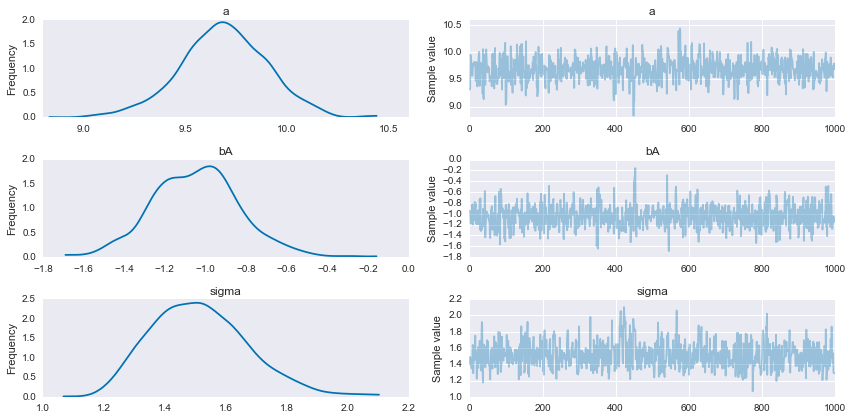

In [4]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_1, varnames);

#### Code 5.2

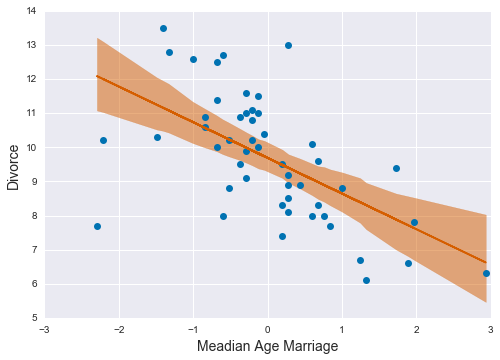

In [5]:
mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.MedianAgeMarriage_s, d.Divorce, 'bo')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'r')

idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

##### Code 5.3

In [6]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [7]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_2 = pm.sample(1000)

100%|██████████| 1000/1000 [00:02<00:00, 419.06it/s]


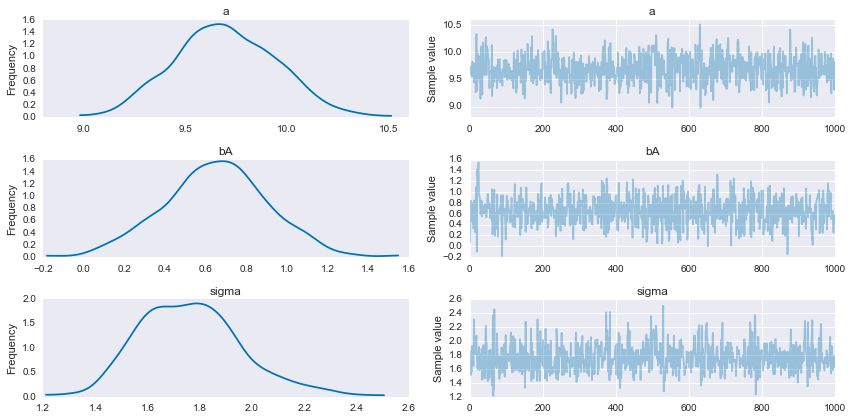

In [8]:
pm.traceplot(trace_5_2, varnames);

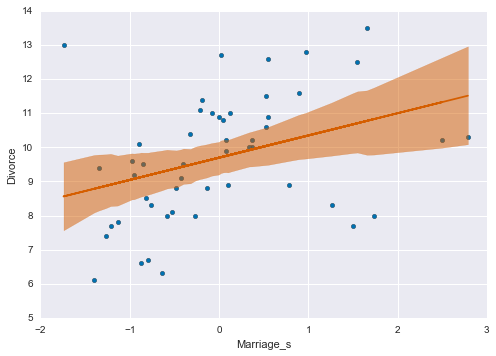

In [9]:
mu_mean = trace_5_2['mu']
mu_hpd = pm.hpd(mu_mean)

d.plot('Marriage_s', 'Divorce', kind='scatter', xlim = (-2, 3))
plt.plot(d.Marriage_s, mu_mean.mean(0), 'r')

idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5);

#### Code 5.4

In [10]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(1000)

100%|██████████| 1000/1000 [00:03<00:00, 306.23it/s]


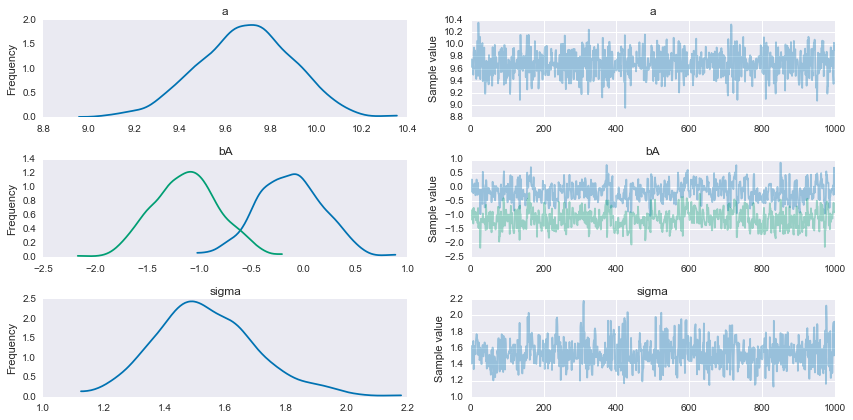

In [11]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_3, varnames);

In [12]:
pm.df_summary(trace_5_3, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,9.686757,0.206755,0.007040,9.282713,10.060090
bA__0,-0.130382,0.316946,0.017156,-0.762039,0.452306
bA__1,-1.124497,0.316211,0.016909,-1.717586,-0.520854
sigma,1.537156,0.167893,0.007215,1.214753,1.880249


#### Code 5.5

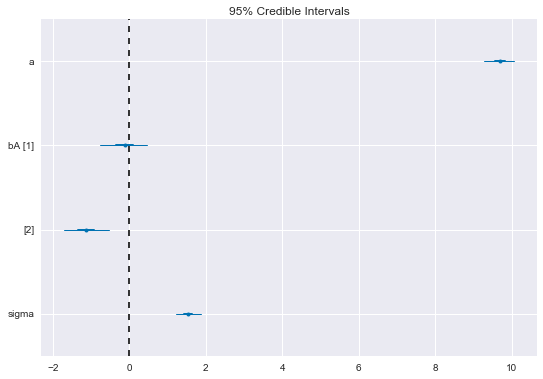

In [13]:
pm.forestplot(trace_5_3, varnames);

#### Code 5.6

In [14]:
with pm.Model() as model_5_4:
    a = pm.Normal('a', mu=10, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000)

100%|██████████| 1000/1000 [00:02<00:00, 389.79it/s]


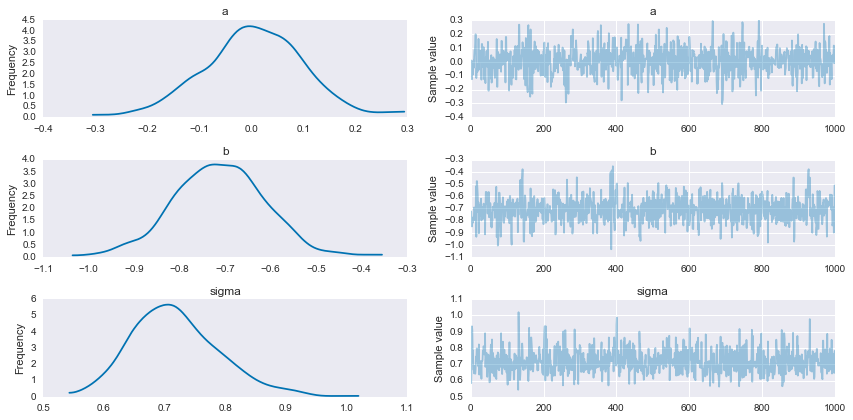

In [15]:
varnames = ['a', 'b', 'sigma']
pm.traceplot(trace_5_4, varnames);

#### Code 5.7

In [16]:
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.Marriage_s - mu_pred

#### Code 5.8

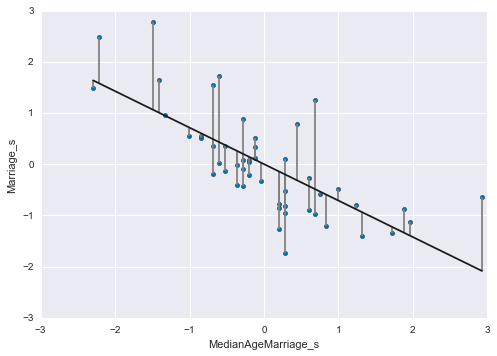

In [17]:
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred[idx], 'k')
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, colors='grey');

#### Code 5.9

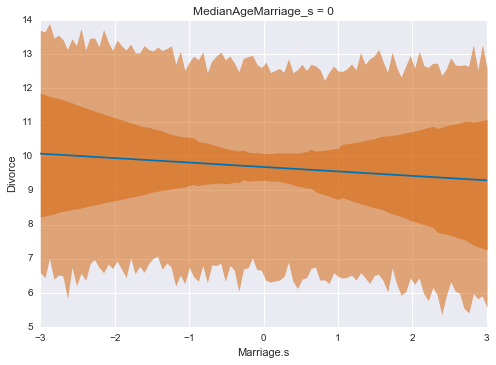

In [18]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,0] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'b');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='r', alpha=0.5)

plt.xlabel('Marriage.s')
plt.ylabel('Divorce')
plt.title('MedianAgeMarriage_s = 0');

#### Code 5.10

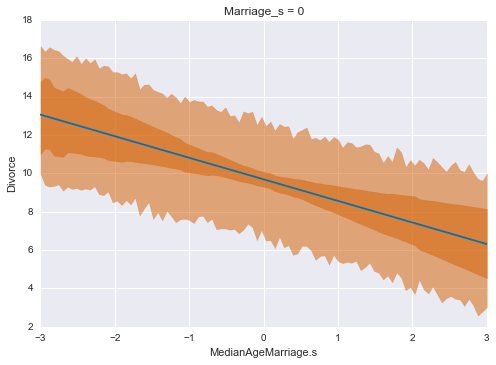

In [19]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,1] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)


plt.plot(R_avg, mu_pred.mean(1), 'b');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='r', alpha=0.5)

plt.xlabel('MedianAgeMarriage.s')
plt.ylabel('Divorce')
plt.title('Marriage_s = 0');

#### Code 5.11

In [20]:
mu_pred = trace_5_3['mu']
mu_hpd = pm.hpd(mu_pred)

divorce_pred = pm.sample_ppc(trace_5_3, samples=1000, model=model_5_3)['Divorce']
divorce_hpd = pm.hpd(divorce_pred)

100%|██████████| 1000/1000 [00:19<00:00, 50.86it/s]    | 1/1000 [00:00<05:06,  3.26it/s]


#### Code 5.12

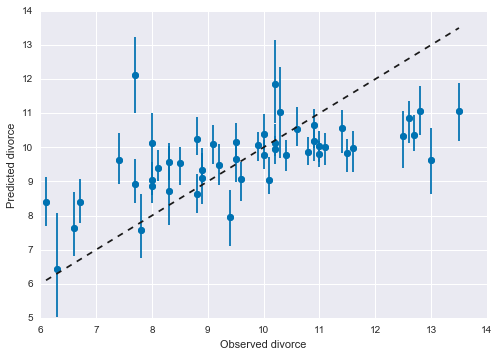

In [21]:
mu_hpd = pm.hpd(mu_pred, alpha=0.05)
plt.errorbar(d.Divorce, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0)-mu_hpd.T) , fmt='bo')
plt.plot(d.Divorce, divorce_pred.mean(0), 'bo')

plt.xlabel('Observed divorce')
plt.ylabel('Predicted divorce')

min_x, max_x = d.Divorce.min(), d.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

#### Code 5.14

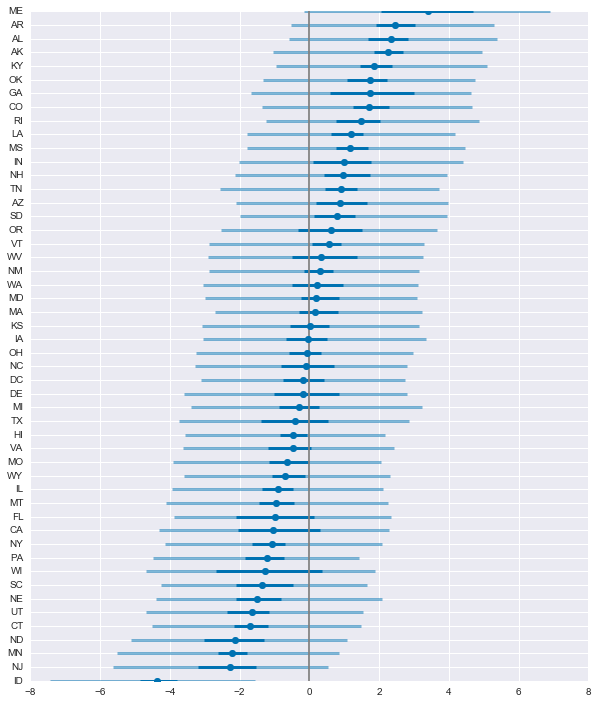

In [22]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-mu_hpd.T),
             fmt='bo',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-divorce_hpd.T),
             fmt='bo', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey');

#### Code 5.15

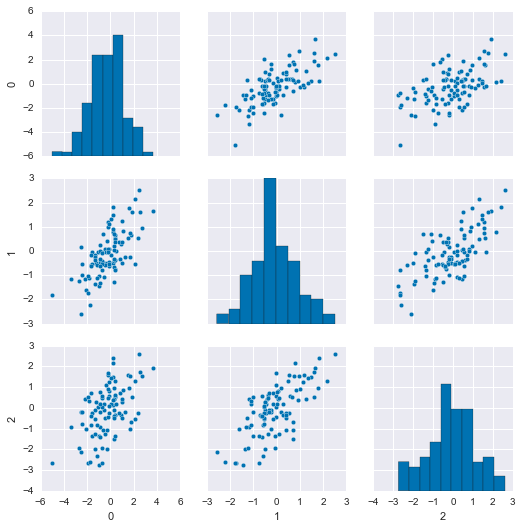

In [23]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.16

In [24]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### Code 5.17 to 5.20

In [25]:
dcc = d.dropna().copy()

In [26]:
with pm.Model() as model_5_5:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['neocortex.perc'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_5 = pm.sample(1000)

100%|██████████| 1000/1000 [00:11<00:00, 89.96it/s]


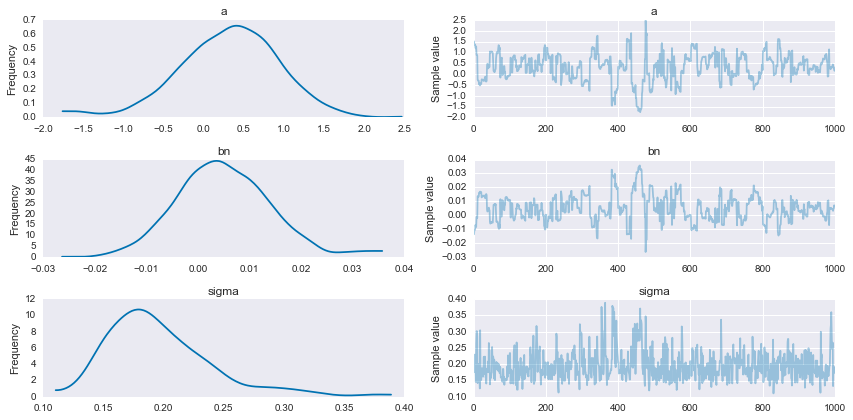

In [27]:
varnames = ['a', 'bn', 'sigma']
pm.traceplot(trace_5_5, varnames);

#### Code 5.21

In [28]:
pm.df_summary(trace_5_5, varnames).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.316,0.622,0.052,-0.885,1.504
bn,0.005,0.009,0.001,-0.014,0.021
sigma,0.197,0.045,0.003,0.134,0.304


#### Code 5.22

In [29]:
trace_5_5['bn'].mean() * (76 - 55)

0.10552565156147953

#### Code 5.23

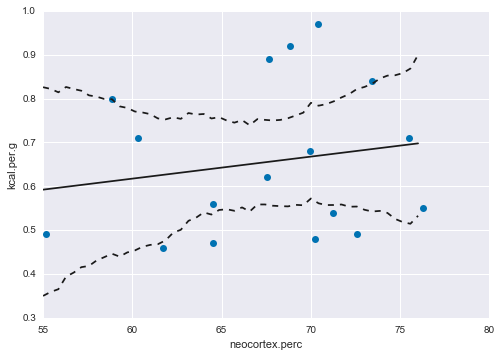

In [30]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_5['a'] + trace_5_5['bn'] * seq[:,None]
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(d['neocortex.perc'], d['kcal.per.g'], 'bo')

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.24

In [31]:
dcc['log_mass'] = np.log(dcc['mass'])

#### Code 5.25

In [32]:
with pm.Model() as model_5_6:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_6 = pm.sample(1000)

100%|██████████| 1000/1000 [00:02<00:00, 356.32it/s]


In [33]:
pm.df_summary(trace_5_6, varnames).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.71,0.06,0.0,0.57,0.83
bn,-0.03,0.03,0.0,-0.08,0.03
sigma,0.18,0.04,0.0,0.12,0.26


#### Code 5.26

In [34]:
with pm.Model() as model_5_7:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn[0] * dcc['neocortex.perc'] + bn[1] * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_7 = pm.sample(1000)

100%|██████████| 1000/1000 [00:18<00:00, 54.33it/s]


In [35]:
pm.df_summary(trace_5_7, varnames).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,-0.93,1.03,0.09,-2.72,0.17
bn__0,0.03,0.02,0.00,0.01,0.05
bn__1,-0.09,0.05,0.00,-0.17,-0.03
sigma,0.15,0.05,0.00,0.08,0.21


#### Code 5.27

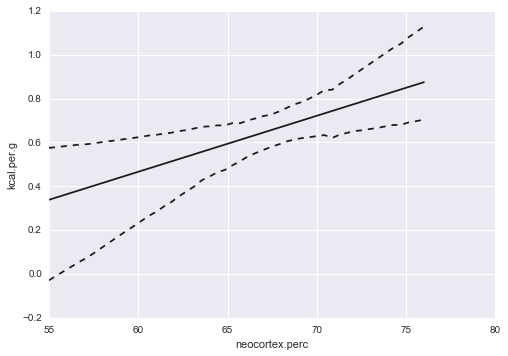

In [36]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_7['a'] + trace_5_7['bn'][:,0] * seq[:,None] + trace_5_7['bn'][:,1] * dcc['log_mass'].mean()
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.28

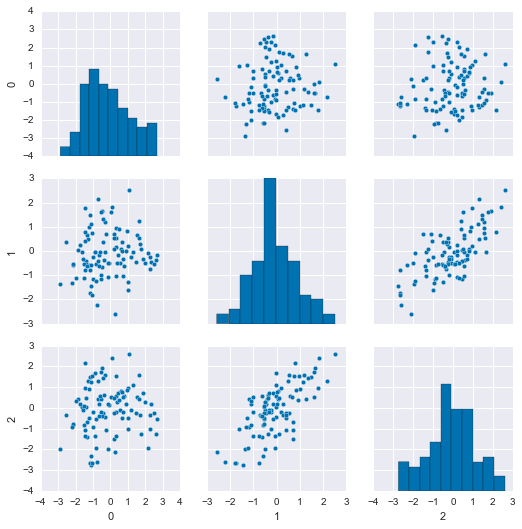

In [37]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(rho*x_pos, (1-rho**2)**0.5)
y = stats.norm.rvs(x_pos - x_neg)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.29

In [38]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5) 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
d = pd.DataFrame([height,leg_left,leg_right])
d

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,8.663108,10.368770,10.692465,8.608439,14.558725,8.285934,12.090322,11.036710,12.272542,10.993193,...,11.447275,12.377798,11.830701,8.964796,10.056511,13.571106,6.699831,8.698357,8.609623,5.038010
1,5.710862,4.674056,6.960919,4.275238,11.668024,4.238000,7.669965,6.453863,7.810795,6.046014,...,6.655540,10.544614,8.549527,7.677071,8.339242,10.216178,2.940950,6.305801,5.108719,2.659745
2,5.710467,4.583661,6.962093,4.262544,11.693914,4.183819,7.686477,6.466669,7.811879,6.091065,...,6.665116,10.553265,8.534767,7.632668,8.312671,10.187515,2.931605,6.323641,5.104117,2.656833


#### Code 5.30

In [39]:
with pm.Model() as m5_8:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    br = pm.Normal('br',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left + br * leg_right)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=d)
    trace_5_8 = pm.sample(1000)

100%|██████████| 1000/1000 [02:50<00:00, 15.06it/s]


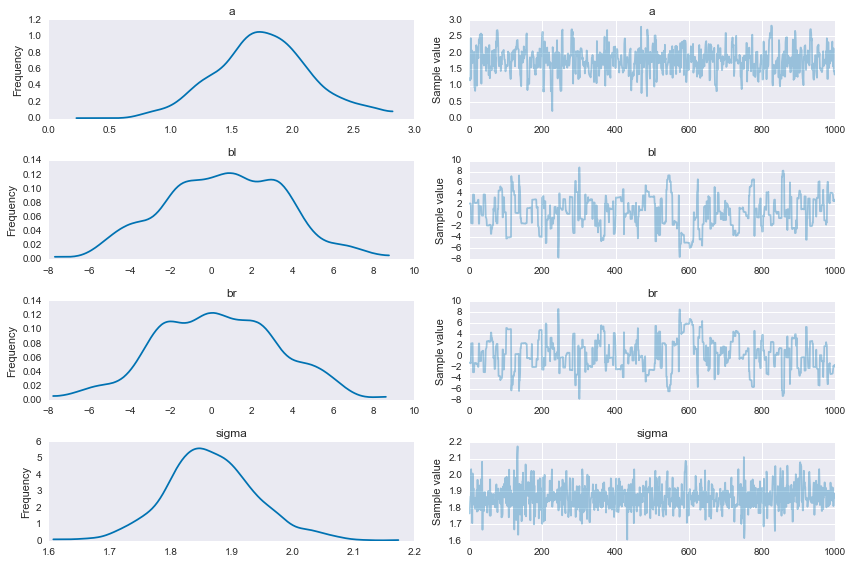

In [40]:
varnames=['a', 'bl', 'br', 'sigma']
pm.traceplot(trace_5_8, varnames);

#### Code 5.31

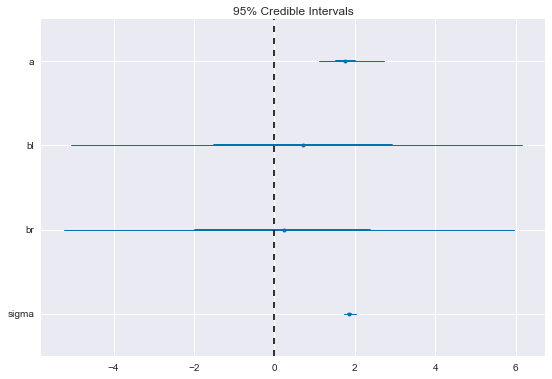

In [42]:
pm.forestplot(trace_5_8, varnames);

#### Code 5.32

In [ ]:
plt.scatter(trace_5_8['br'], trace_5_8['bl']);

#### Code 5.33

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


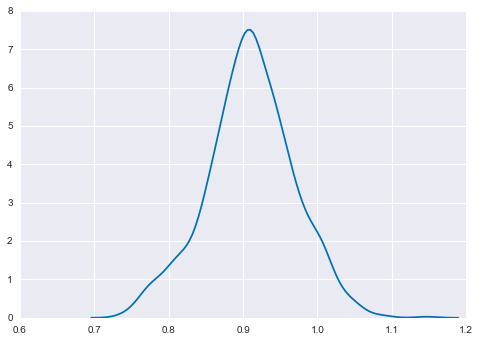

In [43]:
sum_blbr = trace_5_8['br'] + trace_5_8['bl']
sns.kdeplot(sum_blbr);

#### Code 5.34

In [44]:
with pm.Model() as m5_9:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=d)
    trace_5_9 = pm.sample(1000)

100%|██████████| 1000/1000 [00:05<00:00, 183.22it/s]


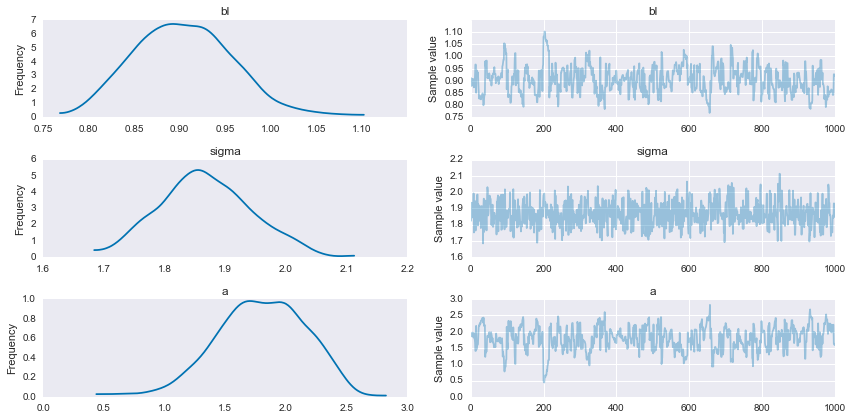

In [47]:
varnames_1 = ['bl', 'sigma', 'a']
pm.traceplot(trace_5_9, varnames_1);

#### Code 5.35

In [48]:
milk = pd.read_csv('Data/milk.csv', sep=';')
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### Code 5.36

In [49]:
with pm.Model() as m5_10:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_10 = pm.sample(1000)

100%|██████████| 1000/1000 [00:04<00:00, 215.17it/s]


In [50]:
varnames = ['a', 'bf', 'sigma']
pm.df_summary(trace_5_10, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.298771,0.035240,0.002334,0.226958,0.365077
bf,0.010077,0.000950,0.000062,0.008297,0.012063
sigma,0.079338,0.011871,0.000569,0.058346,0.103977


In [51]:
with pm.Model() as m5_11:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_11 = pm.sample(1000)

100%|██████████| 1000/1000 [00:04<00:00, 205.39it/s]


In [52]:
varnames = ['a', 'bl', 'sigma']
pm.df_summary(trace_5_11, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,1.165316,0.048883,0.003543,1.058293,1.249558
bl,-0.010560,0.000942,0.000068,-0.012271,-0.008659
sigma,0.067552,0.010015,0.000425,0.049380,0.086215


#### Code 5.37

In [53]:
with pm.Model() as m5_12:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'] + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_12 = pm.sample(1000)

100%|██████████| 1000/1000 [00:15<00:00, 64.15it/s]


In [54]:
varnames = ['a', 'bf', 'bl', 'sigma']
pm.df_summary(trace_5_12, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,1.023842,0.285651,0.024288,0.492380,1.563263
bf,0.001767,0.003463,0.000291,-0.004479,0.008852
bl,-0.008921,0.003437,0.000292,-0.014930,-0.001913
sigma,0.068929,0.011916,0.000668,0.051770,0.091053


#### Code 5.38

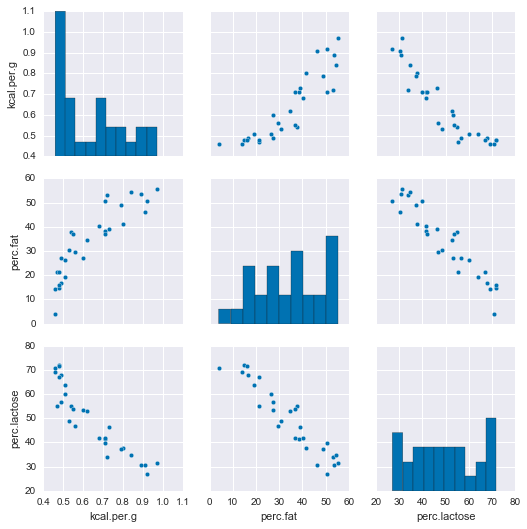

In [55]:
df = milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

In [56]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.5.2
IPython 5.1.0
PyMC3 3.0.rc6
NumPy 1.11.2
Pandas 0.19.2
SciPy 0.18.1
Matplotlib 1.5.3
Seaborn 0.7.1

